In [1]:
import pandas as pd

In [28]:
import pandas as pd

import numpy as np
from numpy import exp, log

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.ioff()
sns.set()

from functools import partial

In [4]:
df = pd.read_excel('CCRB_database_raw.xlsx')

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 323911 entries, 0 to 323910
Data columns (total 14 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   AsOfDate           323911 non-null  datetime64[ns]
 1   Unique Id          323911 non-null  int64         
 2   First Name         323906 non-null  object        
 3   Last Name          323911 non-null  object        
 4   Rank               323911 non-null  object        
 5   Command            323911 non-null  object        
 6   ShieldNo           323855 non-null  float64       
 7   Complaint Id       290649 non-null  float64       
 8   Incident Date      270418 non-null  datetime64[ns]
 9   FADO Type          290649 non-null  object        
 10  Allegation         290228 non-null  object        
 11  Board Disposition  290649 non-null  object        
 12  NYPDDisposition    11464 non-null   object        
 13  PenaltyDesc        9992 non-null    object  

In [10]:
df.describe()

,Unique Id,ShieldNo,Complaint Id
count,323911.000000,323855.000000,2.906490e+05
mean,39220.746721,8393.289228,1.263439e+08
std,22824.135790,9262.194906,9.356904e+07
min,1.000000,0.000000,6.278008e+06
25%,19168.000000,1620.000000,9.404761e+06
50%,39457.000000,4667.000000,2.004009e+08
75%,56169.000000,13053.000000,2.011027e+08
max,81550.000000,93187.000000,2.020037e+08


In [11]:
df.head()

,AsOfDate,Unique Id,First Name,Last Name,Rank,Command,ShieldNo,Complaint Id,Incident Date,FADO Type,Allegation,Board Disposition,NYPDDisposition,PenaltyDesc
0,2020-07-14,43921,Richard,Aalbue,POM,H BKLYN,3619.0,6290465.0,NaT,Force,Force,Unsubstantiated,NaN,NaN
1,2020-07-14,52580,Walter,Aanonsen,LT,MOUNTED,0.0,8300607.0,NaT,Force,Force,Complainant Unavailable,NaN,NaN
2,2020-07-14,52580,Walter,Aanonsen,LT,MOUNTED,0.0,8800504.0,1988-02-15,Force,Beat,Unsubstantiated,NaN,NaN
3,2020-07-14,52580,Walter,Aanonsen,LT,MOUNTED,0.0,9201176.0,1992-04-02,Abuse of Authority,Vehicle Searched,Unsubstantiated,NaN,NaN
4,2020-07-14,52580,Walter,Aanonsen,LT,MOUNTED,0.0,9201176.0,1992-04-02,Discourtesy,Nasty Words,Unsubstantiated,NaN,NaN


In [12]:
len(df)

323911

# 0. Formatting

In [20]:
df.rename(lambda col : col.lower().replace(' ', '_'), axis = 'columns', inplace = True)

In [23]:
counts = df.groupby('unique_id').apply(lambda df : len(df.complaint_id.unique()))

# 1. Negative Binomial

In [14]:
from scipy.stats import nbinom
from statsmodels.base.model import GenericLikelihoodModel
from scipy.optimize import minimize

In [15]:
def log_likelihood_nbinom(counts, r, p, loc):
  model = nbinom(r, p, loc = loc)
  log_likelihood = model.logpmf(counts)
  return -log_likelihood.sum()

In [16]:
log_likelihood = lambda params : log_likelihood_nbinom(counts, *params, 1)

In [38]:
counts.describe()

count    81550.000000
mean         2.287652
std          2.544950
min          1.000000
25%          1.000000
50%          1.000000
75%          3.000000
max         41.000000
dtype: float64

In [31]:
# guess with method of moments. But this doesn't work
e_x = counts.mean()
v_x = counts.var()

r = e_x ** 2 / (v_x - e_x)
p = 1 - e_x / v_x
print(r, p)

r, p = 1.3, 0.1 # Nelder-Mead gets us close enough for convergence

1.2492720247196636 0.6467913630004483


In [39]:
guess = np.array([1.1, 0.6])
result = minimize(log_likelihood, guess, method = 'tnc')

result

     fun: 129873.62049292133
     jac: array([ 7751.24644861, 27103.58094191])
 message: 'Linear search failed'
    nfev: 68
     nit: 1
  status: 4
 success: False
       x: array([1.11217492, 0.49806201])

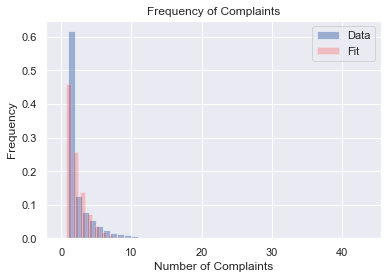

In [ ]:
r, p = result.x
model = nbinom(r, p, loc = 1)
x_max = max(counts) + 1 + 2
bins = range(x_max)
fig, ax = plt.subplots()
sns.distplot(counts, norm_hist = True, kde = False, bins = bins, ax = ax, hist_kws = {'alpha' : 0.5, 'label' : 'Data'})
ax.set_xlabel('Number of Complaints')
ax.set_ylabel('Frequency')
ax.set_title('Frequency of Complaints')

xs = np.arange(1, x_max)
ys = model.pmf(xs)

ax.bar(xs, ys, color = 'red', alpha = 0.2, label = 'Fit')
ax.legend();

plt.show()

log_likelihood = counts.map(model.logpmf).mean()
print(f'Log Likelihood: {log_likelihood:.3f}')